In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import dask
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
client = dask.distributed.Client()

In [2]:
online_group = "zc-emu-1year-run-normfix-precpd-clip-v1-online"
offline_group = "zc-emu-1year-run-segmented-v2-offline"

In [3]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [4]:
def _prepare_global_average(group, field):
    data = common.open_group(group)
    average_dims = list(set(data[field].dims) - set(["time", "z"]))
    field_data = data[field]

    return vcm.weighted_average(field_data, grid.area, dims=average_dims)

In [46]:
fields = ["air_temperature", "specific_humidity", "cloud_water_mixing_ratio", "total_precipitation"]
extra_fields = [
    "PWAT",
    "ULWRFtoa",
    "USWRFtoa",
    "h500",
]

In [6]:
args = list(product([online_group, offline_group], fields + extra_fields))


In [7]:

jobs = [delayed(_prepare_global_average)(g, f) for g, f in args]
to_load = Parallel(n_jobs=8)(jobs)

In [8]:
arg_to_load_map = {a: v for a, v in zip(args, to_load)}

In [9]:
@common.memoize_xarray_out
def get_global_average_v1(group, field):
    return arg_to_load_map[(group, field)].load()

In [10]:
results = [get_global_average_v1(*key) for key in args]    

In [11]:
offline = xr.Dataset()
online = xr.Dataset()

for (group, _), res in zip(args, results):
    if "offline" in group:
        offline = offline.merge(res)
    else:
        online = online.merge(res)

offline["net_outgoing"] = offline["USWRFtoa"] + offline["ULWRFtoa"]
online["net_outgoing"] = online["USWRFtoa"] + online["ULWRFtoa"]

In [12]:
diff = (online - offline).mean().to_pandas()


In [13]:
online["USWRFtoa"].values.shape

(3000,)

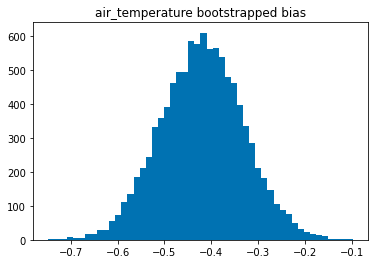

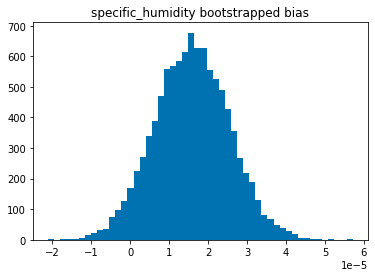

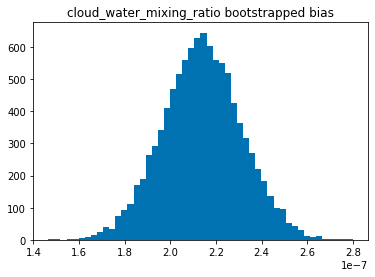

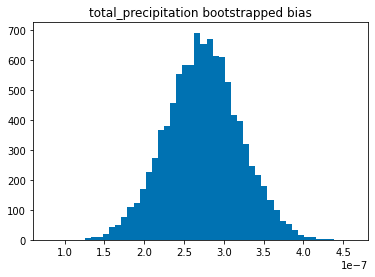

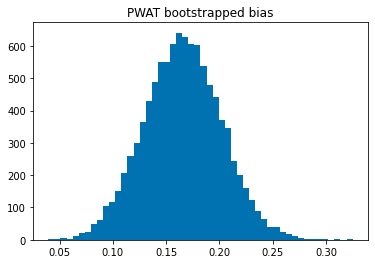

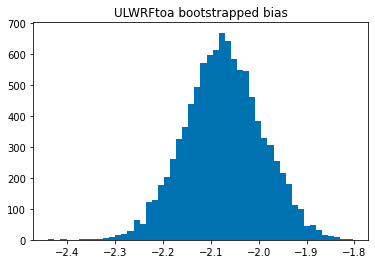

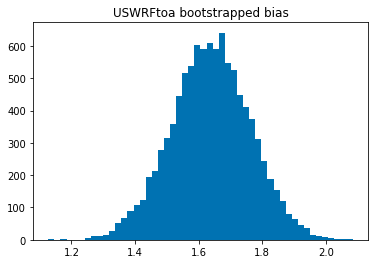

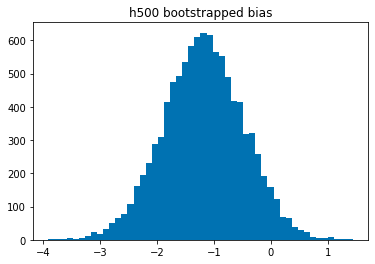

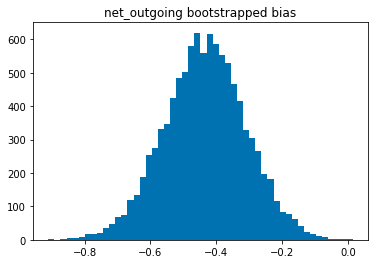

In [87]:
signif = {}
for k in online.keys():
    b, s = common.bootstrap_bias_signif(offline[k].values.flatten(), online[k].values.flatten())
    plt.hist(b, bins=50)
    plt.title(f"{k} bootstrapped bias")
    plt.show()
    signif[k] = s

In [88]:
pd.Series(signif, name="95% significance")

air_temperature              True
specific_humidity           False
cloud_water_mixing_ratio     True
total_precipitation          True
PWAT                         True
ULWRFtoa                     True
USWRFtoa                     True
h500                        False
net_outgoing                 True
Name: 95% significance, dtype: bool

In [19]:
out_bias_df = common.limit_sigfigs(diff.to_frame(name="bias"))
baseline_mean = common.limit_sigfigs(offline.mean().to_pandas())
pct = (diff / offline.mean().to_pandas() * 100).round(2)
out_bias_df["baseline mean"] = baseline_mean
out_bias_df["% change"] = pct
out_bias_df.to_csv("online_bias_1yr_run.csv")
out_bias_df

,bias,baseline mean,% change
air_temperature,-4.200000e-01,247.000000,-0.17
specific_humidity,1.590000e-05,0.002680,0.59
cloud_water_mixing_ratio,2.140000e-07,0.000008,2.80
total_precipitation,2.730000e-07,0.000032,0.87
PWAT,1.650000e-01,26.400000,0.63
ULWRFtoa,-2.070000e+00,237.000000,-0.88
USWRFtoa,1.640000e+00,92.100000,1.78
h500,-1.180000e+00,5660.000000,-0.02
net_outgoing,-4.360000e-01,329.000000,-0.13


In [22]:
names = {
    "air_temperature": "Air temperature [K]",
    "specific_humidity": "Specific humidity [g/kg]",
    "cloud_water_mixing_ratio": "Cloud water [g/kg]",
    "PWAT": "Precipitable water [kg/m$^2$]",
    "total_precipitation": "Surface precipitation [mm/day]",
    "USWRFtoa": "Upward shortwave at TOA [W/m$^2$]",
    "ULWRFtoa": "Upward longwave at TOA [W/m$^2$]",
    "net_outgoing": "Total outgoing radiation at TOA [W/m$^2$]",
    "h500": "500 hPa height [m]",
}

scale_functions = {
    "specific_humidity": lambda x: x * 1000,
    "cloud_water_mixing_ratio": lambda x: x * 1000,
    "total_precipitation": common.m_to_mm_day,
}

bias_values = []
new_names = []
offline_avg = []
pct_change = []
for key, new_name in names.items():
    scale_func = scale_functions.get(key, lambda x: x)
    bias_values.append(scale_func(diff[key]))
    offline_avg.append(scale_func(baseline_mean[key]))
    pct_change.append(pct[key])
for_table = pd.DataFrame({"bias": bias_values, "baseline mean": offline_avg, "% change": pct_change}, index=names.values())
for_table["bias"] = common.limit_sigfigs(for_table["bias"])
for_table

,bias,baseline mean,% change
Air temperature [K],-0.420000,247.00000,-0.17
Specific humidity [g/kg],0.015900,2.68000,0.59
Cloud water [g/kg],0.000214,0.00763,2.80
Precipitable water [kg/m$^2$],0.165000,26.40000,0.63
Surface precipitation [mm/day],0.026200,3.03360,0.87
Upward shortwave at TOA [W/m$^2$],1.640000,92.10000,1.78
Upward longwave at TOA [W/m$^2$],-2.070000,237.00000,-0.88
Total outgoing radiation at TOA [W/m$^2$],-0.436000,329.00000,-0.13
500 hPa height [m],-1.180000,5660.00000,-0.02


In [23]:
print(for_table.to_latex(formatters={"bias": "{:1.2e}".format, "baseline mean": "{:1.2e}".format, "% change": "{:1.2f}".format}))

\begin{tabular}{lrrr}
\toprule
{} &      bias & baseline mean & \% change \\
\midrule
Air temperature [K]                       & -4.20e-01 &      2.47e+02 &    -0.17 \\
Specific humidity [g/kg]                  &  1.59e-02 &      2.68e+00 &     0.59 \\
Cloud water [g/kg]                        &  2.14e-04 &      7.63e-03 &     2.80 \\
Precipitable water [kg/m\$\textasciicircum 2\$]             &  1.65e-01 &      2.64e+01 &     0.63 \\
Surface precipitation [mm/day]            &  2.62e-02 &      3.03e+00 &     0.87 \\
Upward shortwave at TOA [W/m\$\textasciicircum 2\$]         &  1.64e+00 &      9.21e+01 &     1.78 \\
Upward longwave at TOA [W/m\$\textasciicircum 2\$]          & -2.07e+00 &      2.37e+02 &    -0.88 \\
Total outgoing radiation at TOA [W/m\$\textasciicircum 2\$] & -4.36e-01 &      3.29e+02 &    -0.13 \\
500 hPa height [m]                        & -1.18e+00 &      5.66e+03 &    -0.02 \\
\bottomrule
\end{tabular}



In [35]:
\begin{tabular}{lrrr}
\toprule
{} &      bias & baseline mean & \% change \\
\midrule
Air temperature [K]                        & -4.20e-01 &      2.47e+02 &    -0.17 \\
Specific humidity [g/kg]                   &  1.59e-02 &      2.68e+00 &     0.59 \\
Cloud water [g/kg]                         &  2.14e-04 &      7.63e-03 &     2.80 \\
Precipitable water [kg/m\$^2$]             &  1.65e-01 &      2.64e+01 &     0.63 \\
Surface precipitation [mm/day]             &  2.62e-02 &      3.03e+00 &     0.87 \\
Upward shortwave at TOA [W/m\$^2$]         &  1.64e+00 &      9.21e+01 &     1.78 \\
Upward longwave at TOA [W/m\$^2$]          & -2.07e+00 &      2.37e+02 &    -0.88 \\
Total outgoing radiation at TOA [W/m\$^2$] & -4.36e-01 &      3.29e+02 &    -0.13 \\
500 hPa height [m]                         & -1.18e+00 &      5.66e+03 &    -0.02 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrr}
\toprule
{} &      bias & baseline mean & \% change \\
\midrule
    \midrule
    Air temperature [K]                        & -0.42 &      247\\
    Specific humidity [g/kg]                   &  0.0159 &      2.68\\
    Cloud water [g/kg]                         &  2.14e-04 &      7.63e-03\\
    Precipitable water [kg/m$^2$]             &  0.165 &      26.4\\
    Surface precipitation [mm/day]             &  0.0262 &      3.03\\
    Upward shortwave at TOA [W/m$^2$]         &  1.64 &      92.1\\
    Upward longwave at TOA [W/m$^2$]          & -2.07 &      237\\
    Total outgoing radiation at TOA [W/m$^2$] & -0.436 &      329\\
    500 hPa height [m]                         & -1.18 &      5660\\
    \bottomrule
\bottomrule
\end{tabular}


air_temperature            -0.169766
specific_humidity           0.592196
cloud_water_mixing_ratio    2.806502
total_precipitation         0.864822
PWAT                        0.626259
ULWRFtoa                   -0.875271
USWRFtoa                    1.777570
h500                       -0.020791
dtype: float64

In [91]:
run, = common._get_runs(online_group, job_types=["piggy-back"])
use_keys = [
    'column_skill/air_temperature',
    'column_skill/specific_humidity',
    'column_skill/cloud_water',
    'column_skill/surface_precipitation',
]
online_skill = pd.Series({k.replace("column_skill/", ""): v for k, v in run.summary.items() if k in use_keys})
online_skill = online_skill[[k.replace("column_skill/", "") for k in use_keys]]
online_skill = common.limit_sigfigs(online_skill).to_frame(name="Skill score")
with pd.option_context("display.float_format", "{:1.3f}".format):
    print(online_skill)


                       Skill score
air_temperature              0.981
specific_humidity            0.984
cloud_water                  0.938
surface_precipitation        0.966


In [ ]:
# 1-yr Online
Skill score
air_temperature              0.981
specific_humidity            0.984
cloud_water                  0.938
surface_precipitation        0.966

ZC Output & 1-year run online skill & 12 30-day runs online skill  \\
\midrule
$\Delta T$ [K/day]  &       0.981 & 0.981\\
$\Delta q$ [g/kg/day]  &    0.984 & 0.985 \\
$\Delta c$ [g/kg/day]  &    0.938 & 0.941\\
$pr$ [mm/day]  &            0.966 & 0.967\\


# 30-day
  ZC Output & Skill score &      RMSE &      Bias & Skill Score &      RMSE &     Bias \\
    \midrule
    $\Delta T$ [K/day]  &        0.991 &  0.37 & -1.9e-2 &   0.981 &  0.52 & -1.1e-2\\
    $\Delta q$ [g/kg/day]  &        0.995 &  0.10 &  2.5e-3 &        0.985 &  0.18 & -8.6e-4 \\
    $\Delta c$ [g/kg/day]  &        0.987 &  0.13 & -5.6e-4  &        0.941 &  0.28 &  2.5e-4\\
    $pr$ [mm/day]  &        0.998 &  0.21 & -2.0e-2 &        0.967 &  0.77 &  1.8e-2 \\
    \bottomrule
    \end{tabular}

In [54]:

online_skill.to_csv("online_skill_1yr_run.csv")

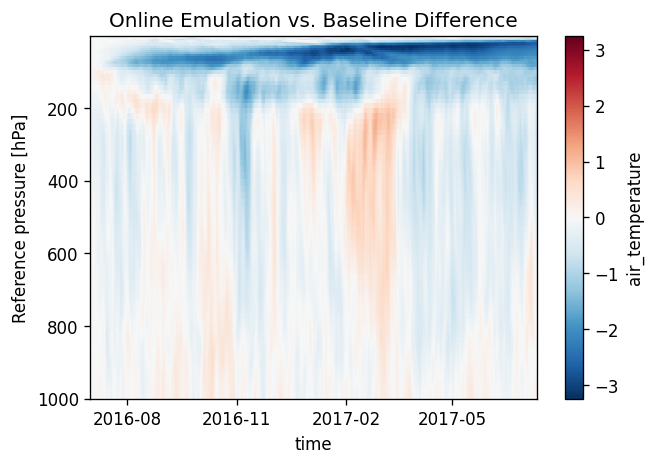

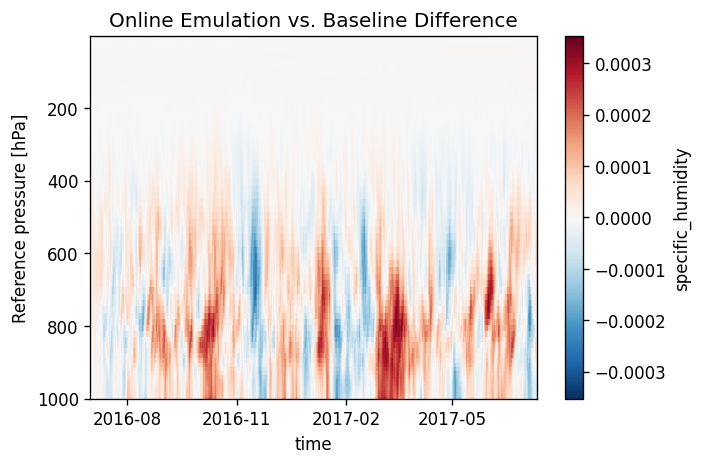

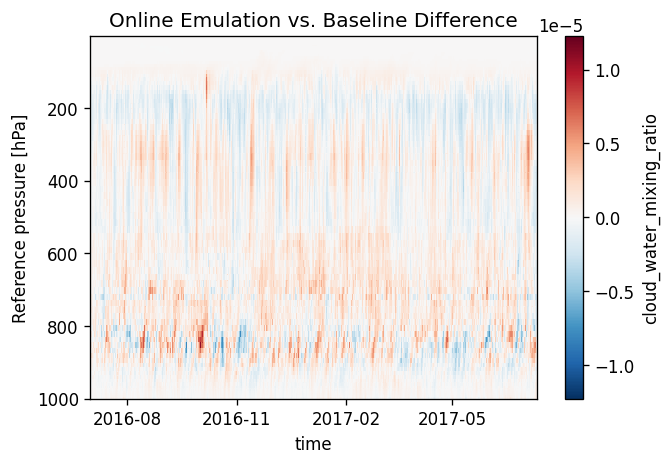

In [16]:
for f in fields:
    if "precip" in f:
        continue
    plt.figure(dpi=120)
    diff[f].plot(y="z", yincrease=False)
    plt.title("Online Emulation vs. Baseline Difference")
    plt.ylabel("Reference pressure [hPa]")
    plt.show()

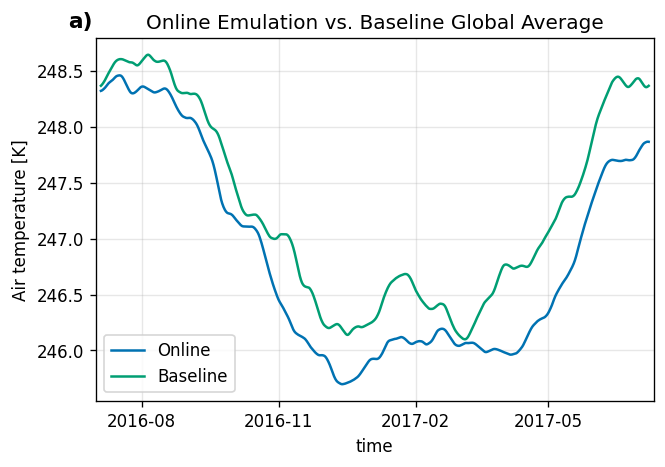

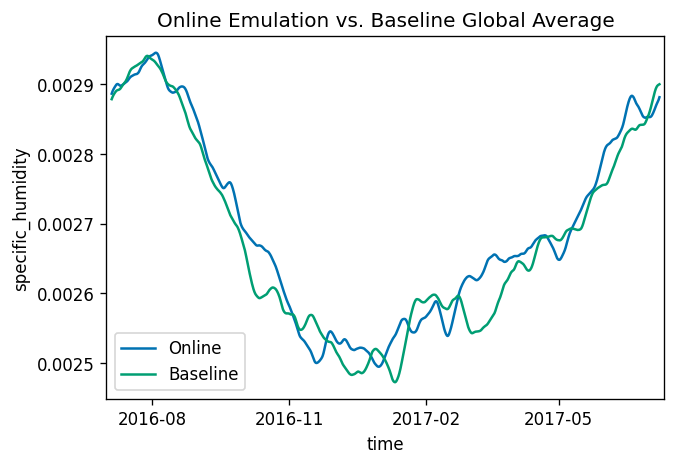

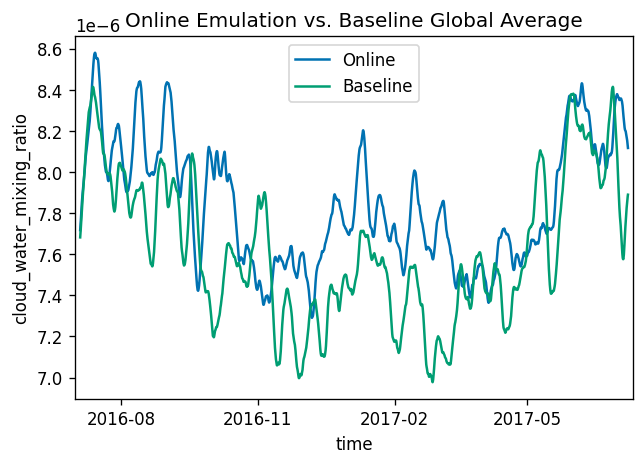

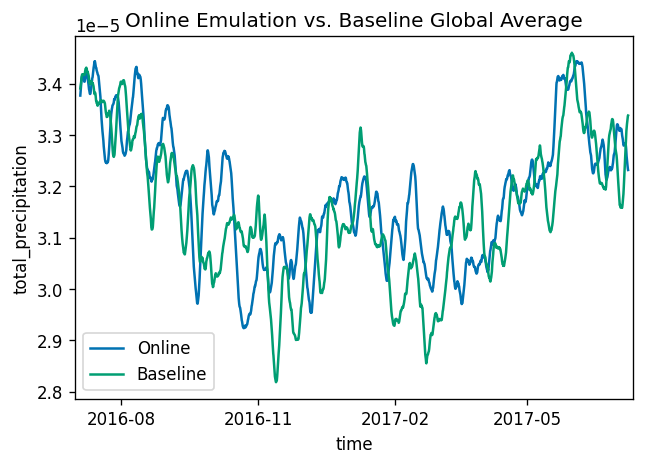

In [87]:
for f in fields:
    if "relative" in f:
        continue
    plt.figure(dpi=120)
    online.mean(dim="z")[f].rolling(time=7*8, center=True).mean().plot(label="Online")
    offline.mean(dim="z")[f].rolling(time=7*8, center=True).mean().plot(label="Baseline")
    plt.title("Online Emulation vs. Baseline Global Average")
    plt.legend()
    if "air" in f:
        plt.text(-0.05, 1.03, "a)", fontdict=dict(size=13, weight="bold"), transform=plt.gca().transAxes)
        plt.ylabel("Air temperature [K]")
        plt.grid(alpha=0.3)

    plt.xlim(online.time.values[0], online.time.values[-1])
    plt.show()

## Hovemoller Diagrams

In [18]:
hov_fields = [
    "total_precipitation",
    "cloud_water_mixing_ratio",
    "PWAT",
    "ULWRFtoa",
    "USWRFtoa",
    "h500",
]

data_source = {
    online_group: common.open_group(online_group),
    offline_group: common.open_group(offline_group)
}

In [19]:
@common.memoize_xarray_out
def get_hovemoller_1yr_testv1(group, field):

    data = data_source[group]

    da = data[field]
    if field == "total_precipitation" :
        da = common.m_to_mm_day(da)
    elif field == "cloud_water_mixing_ratio":
        da = vcm.mass_integrate(
            da,
            data["pressure_thickness_of_atmospheric_layer"],
            dim="z"
        )

    da = vcm.zonal_average_approximate(grid.lat, da)

    return da.to_dataset(name=field).load()

In [16]:
online_zonal = [get_hovemoller_1yr_testv1(group, field) for group, field in product([online_group], hov_fields)]

In [17]:

offline_zonal = [get_hovemoller_1yr_testv1(group, field) for group, field in product([offline_group], hov_fields)]

In [18]:
online_ds = xr.Dataset({
    field: d[field] for field, d in zip(hov_fields, online_zonal)
})

offline_ds = xr.Dataset({
    field: d[field] for field, d in zip(hov_fields, offline_zonal)
})

In [19]:
offline_ds["total_precipitation"].attrs.update({"long_name": "Surface precipitation", "units": "mm/day"})
offline_ds["cloud_water_mixing_ratio"].attrs.update({"long_name": "Column integrated cloud water", "units": "kg/m^2"})

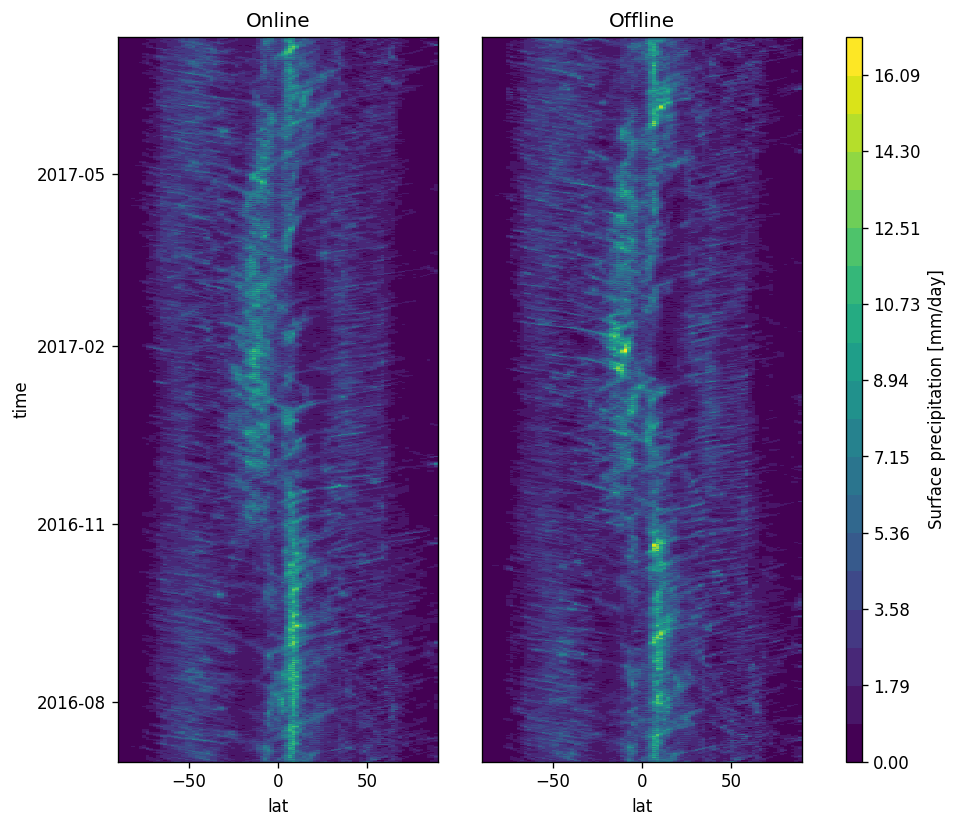

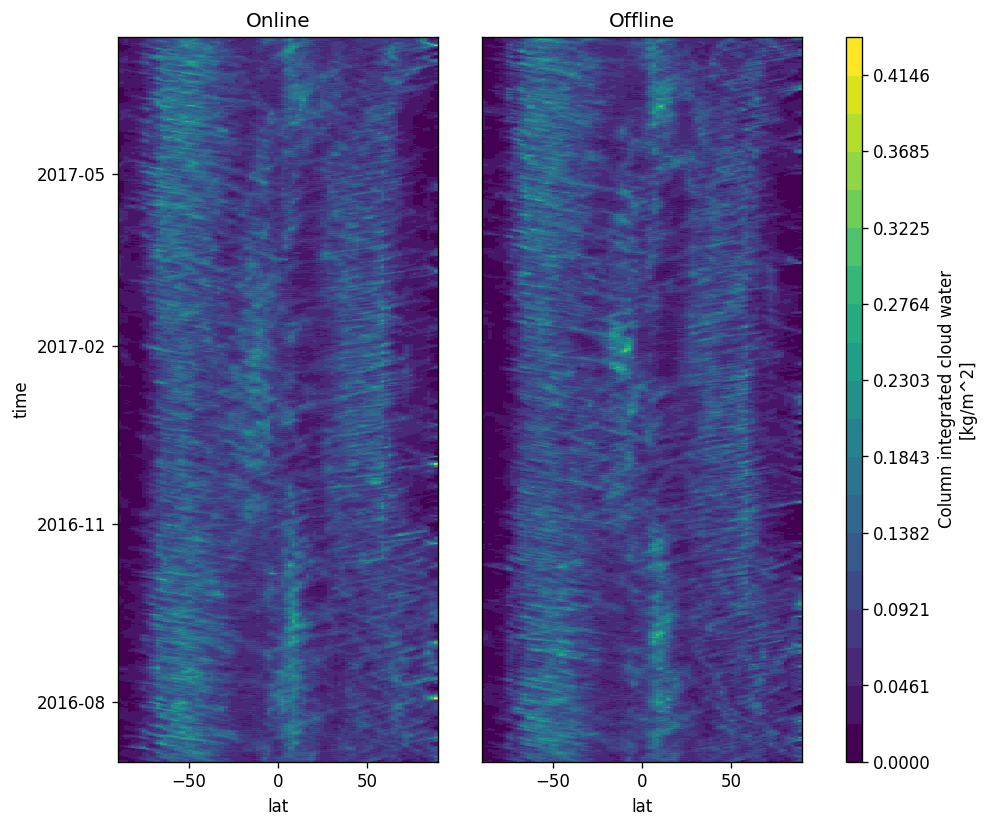

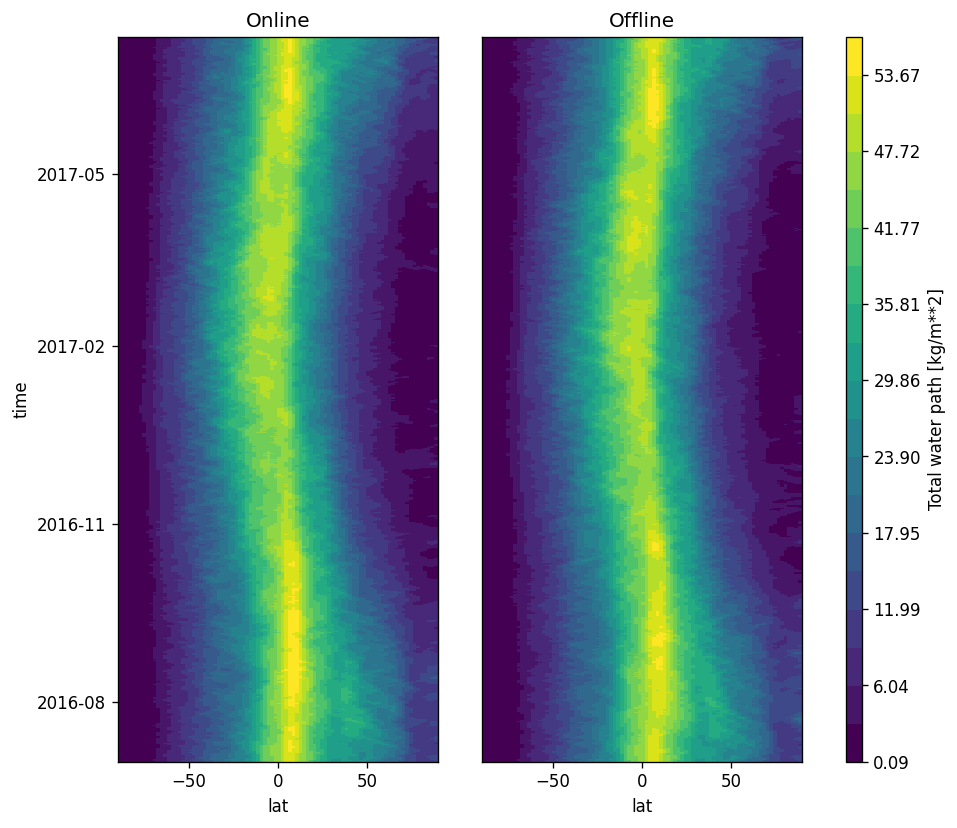

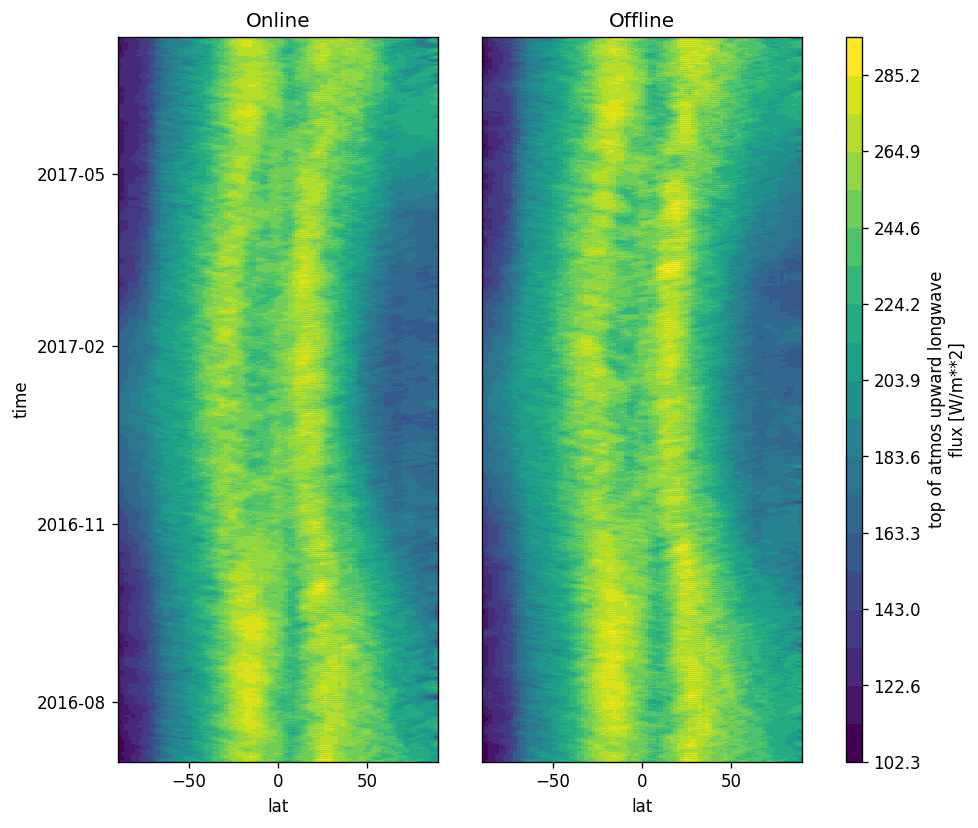

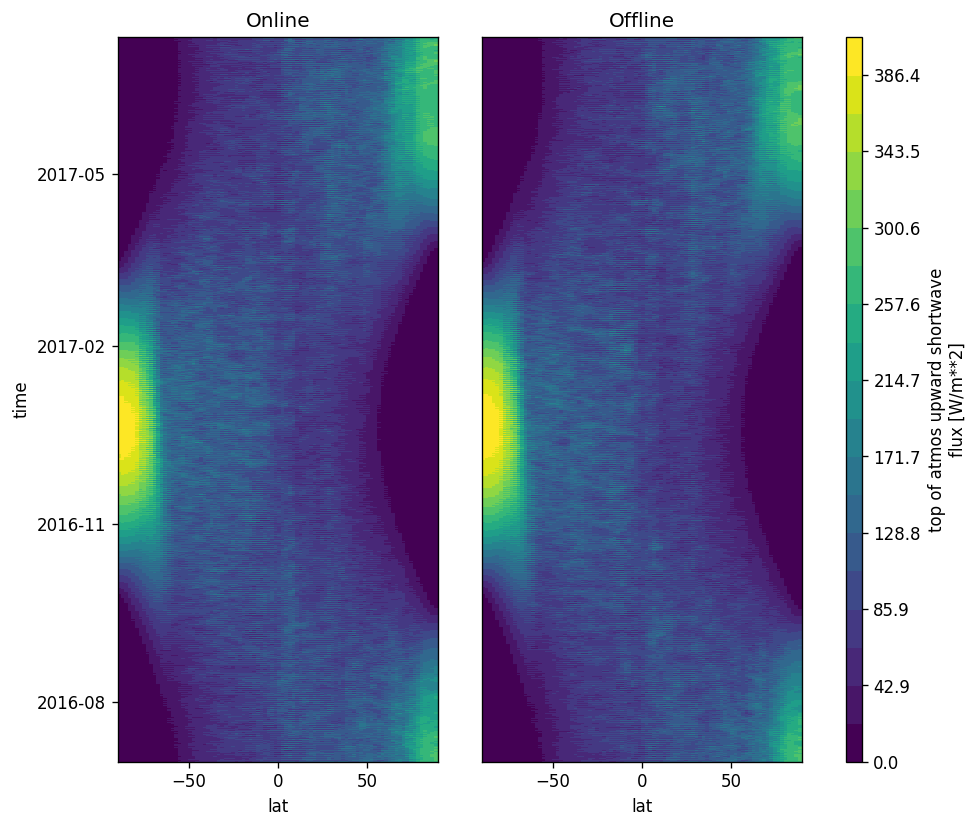

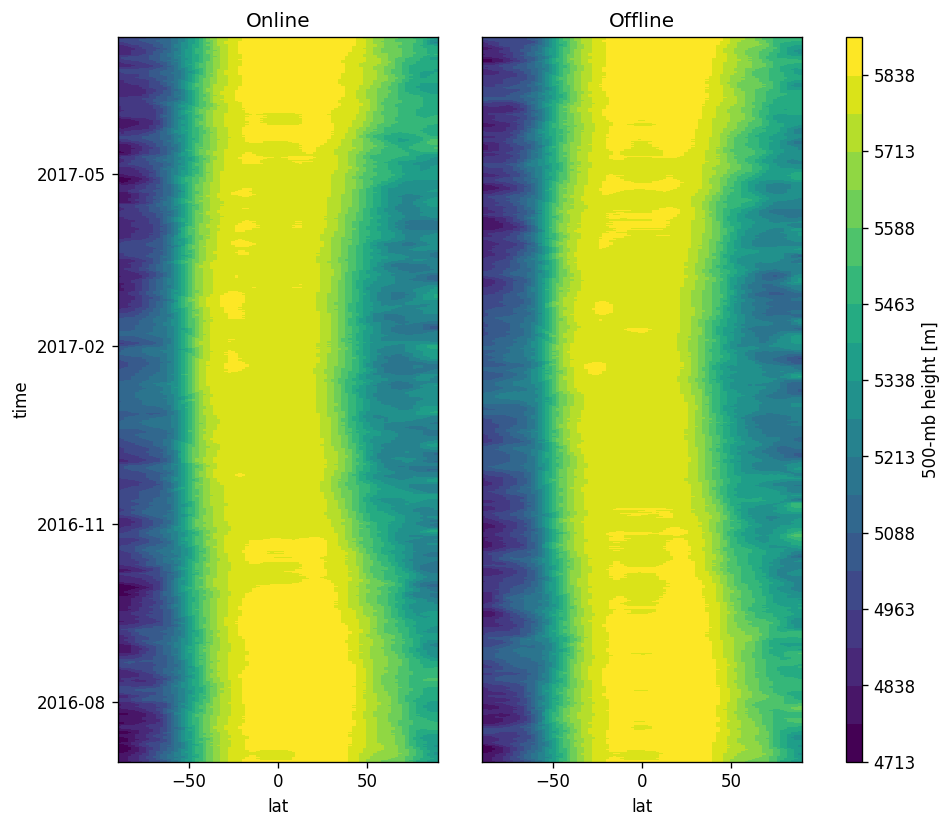

In [20]:
for k, online_v in online_ds.items():
    fig = plt.figure(dpi=120, figsize=(8, 8))
    gs = fig.add_gridspec(1, 3, width_ratios=[20, 20, 1], hspace=0.1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    cbar_ax = fig.add_subplot(gs[2])

    offline_v = offline_ds[k]
    vmin = min(online_v.min(), offline_v.min())
    vmax = max(online_v.max(), offline_v.max())

    online_v.plot(y="time", ax=ax1, vmin=vmin, vmax=vmax, levels=20, add_colorbar=False)
    offline_v.plot(y="time", ax=ax2, vmin=vmin, vmax=vmax, levels=20, cbar_ax=cbar_ax, yticks=[0])
    ax2.set_ylabel("")
    ax1.set_title("Online")
    ax2.set_title("Offline")
    plt.show()

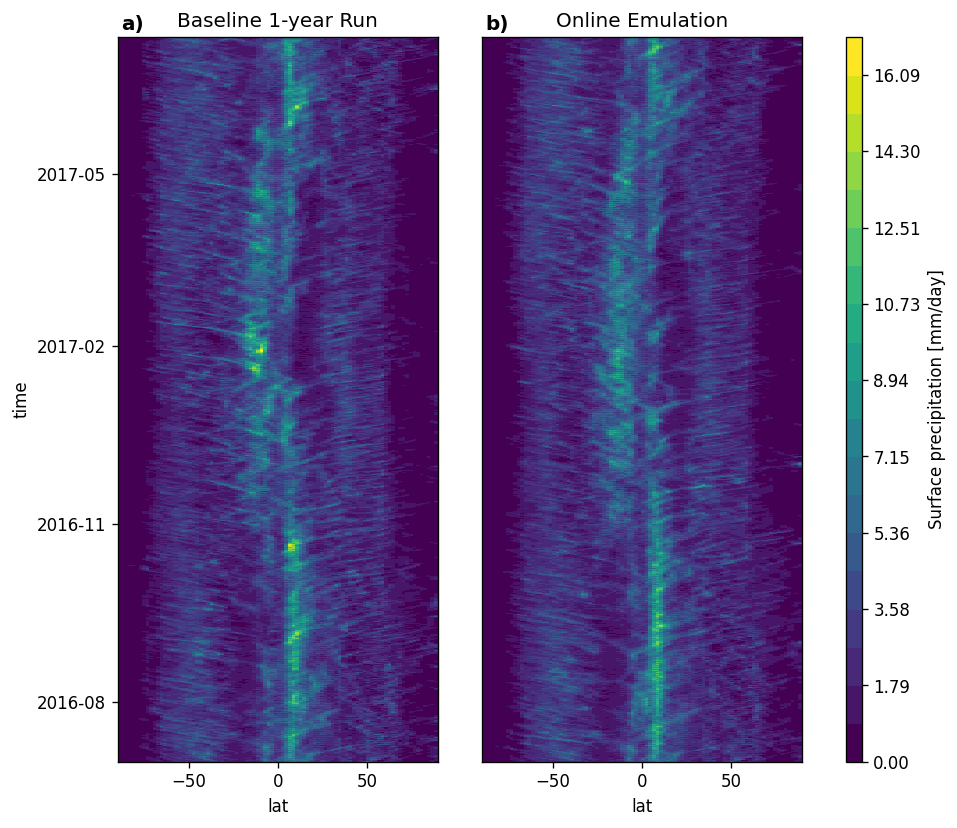

In [41]:

fig = plt.figure(dpi=120, figsize=(8, 8))
gs = fig.add_gridspec(1, 3, width_ratios=[20, 20, 1], hspace=0.1)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
cbar_ax = fig.add_subplot(gs[2])

k = "total_precipitation"
offline_v = offline_ds[k]
online_v = online_ds[k]
vmin = min(online_v.min(), offline_v.min())
vmax = max(online_v.max(), offline_v.max())

offline_v.plot(y="time", ax=ax1, vmin=vmin, vmax=vmax, levels=20, add_colorbar=False, rasterized=True)
ax1.set_title("Baseline 1-year Run")
ax1.text(0.01, 1.01, "a)", fontdict=dict(size=12, weight="bold"), transform=ax1.transAxes)
online_v.plot(y="time", ax=ax2, vmin=vmin, vmax=vmax, levels=20, yticks=[0], cbar_ax=cbar_ax, 
              cbar_kwargs=dict(label="Surface precipitation [mm/day]"), rasterized=True)
ax2.set_title("Online Emulation")
ax2.set_ylabel("")
ax2.text(0.01, 1.01, "b)", fontdict=dict(size=12, weight="bold"), transform=ax2.transAxes)
common.savefig("sfc_pr_hoev_vertical")
plt.show()

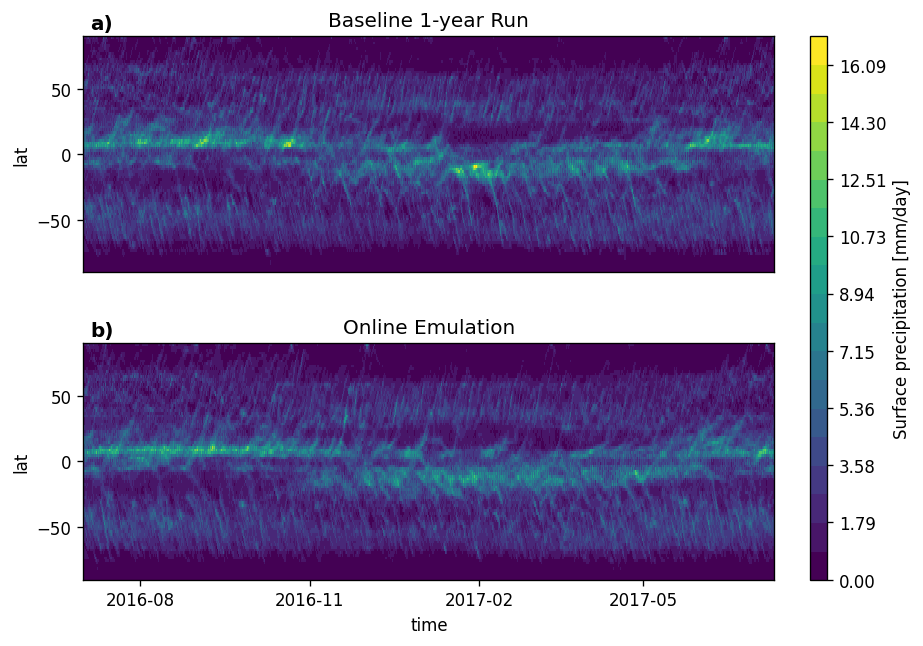

In [42]:

fig = plt.figure(dpi=120, figsize=(8, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[40, 1], hspace=0.3, wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
cbar_ax = fig.add_subplot(gs[0:2, 1])

k = "total_precipitation"
offline_v = offline_ds[k]
online_v = online_ds[k]
vmin = min(online_v.min(), offline_v.min())
vmax = max(online_v.max(), offline_v.max())

offline_v.plot(x="time", ax=ax1, vmin=vmin, vmax=vmax, levels=20, xticks=[0], add_colorbar=False, rasterized=True)
ax1.set_title("Baseline 1-year Run")
ax1.text(0.01, 1.03, "a)", fontdict=dict(size=12, weight="bold"), transform=ax1.transAxes)
ax1.set_xlabel("")
online_v.plot(x="time", ax=ax2, vmin=vmin, vmax=vmax, levels=20, cbar_ax=cbar_ax, 
              cbar_kwargs=dict(label="Surface precipitation [mm/day]"), rasterized=True)
ax2.set_title("Online Emulation")
ax2.text(0.01, 1.03, "b)", fontdict=dict(size=12, weight="bold"), transform=ax2.transAxes)
common.savefig("sfc_pr_hoev_horizontal")
plt.show()

## Zonal Average bias

### Last Month

In [38]:
@common.memoize_xarray_out
def get_zonal_avg_last_3month_v2(group, field):

    data = data_source[group]

    start_time = -1 * 3 * 30 * 8
    da = data[field].isel(time=slice(start_time))

    da = vcm.zonal_average_approximate(grid.lat, da)
    zonal_ds = da.to_dataset(name=field)
        
    return zonal_ds.mean(dim="time").load()

In [47]:
fields.append("relative_humidity")
fields

['air_temperature',
 'specific_humidity',
 'cloud_water_mixing_ratio',
 'total_precipitation',
 'relative_humidity']

In [48]:
def get_RH_field(ds):
    
    delp_key = "pressure_thickness_of_atmospheric_layer"
    pressure = ds[delp_key].cumsum(dim="z") + 300.0
    humidity = ds["specific_humidity"]
    temperature = ds["air_temperature"]
    return vcm.relative_humidity_from_pressure(temperature, humidity, pressure)
    

In [20]:
ds_with_rh = {}
for k, ds in data_source.items():
    rh = get_RH_field(ds)
    ds_with_rh[k] = ds
    ds_with_rh[k]["relative_humidity"] = rh

In [53]:
last_3mo_results = [
    get_zonal_avg_last_3month_v2(group, field) 
    for group, field in product(data_source.keys(), fields)
]

In [50]:
last_3mo_delp = get_zonal_avg_last_3month_v2("zc-emu-1year-run-normfix-precpd-clip-v1-online", "pressure_thickness_of_atmospheric_layer")

In [56]:
delp = last_3mo_delp["pressure_thickness_of_atmospheric_layer"]

In [63]:
offline_ds

<xarray.DataArray (lat: 90, pressure: 69)>
array([[         nan,          nan, 240.92941318, ...,          nan,
                 nan,          nan],
       [         nan,          nan, 240.93927717, ...,          nan,
                 nan,          nan],
       [         nan,          nan, 240.95598532, ...,          nan,
                 nan,          nan],
       ...,
       [         nan,          nan, 231.06602371, ..., 255.86329372,
        255.12971524, 254.51973935],
       [         nan,          nan, 231.03792096, ..., 256.09431783,
        255.33615741, 254.66266748],
       [         nan,          nan, 231.02220311, ..., 256.18983419,
        255.45426454, 254.76096728]])
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * pressure  (pressure) float64 300.0 400.0 500.0 ... 9.75e+04 9.875e+04 1e+05

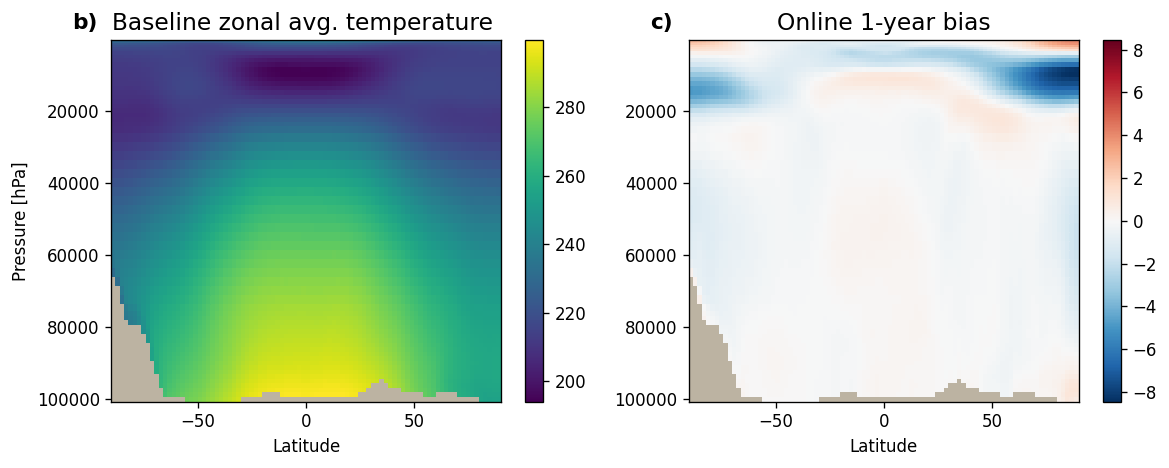

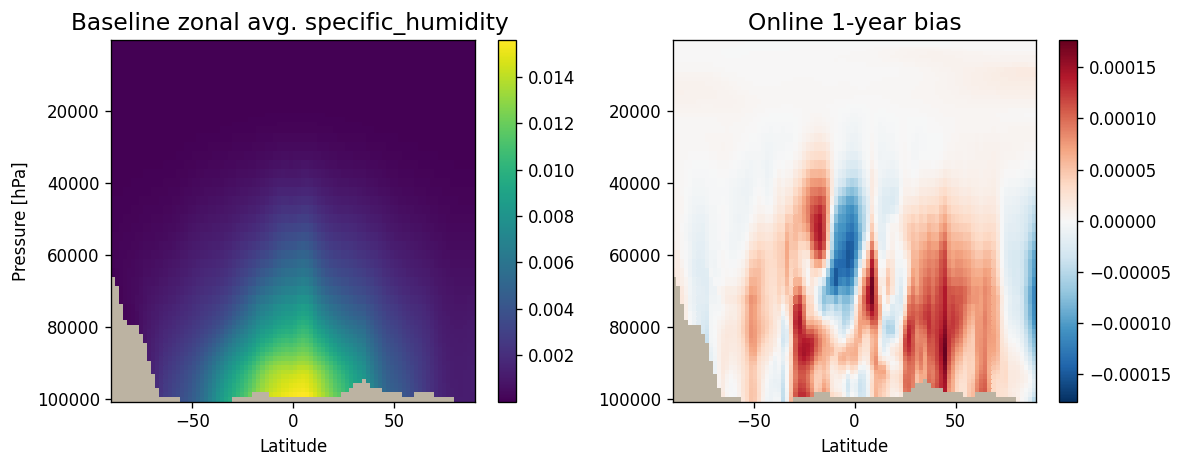

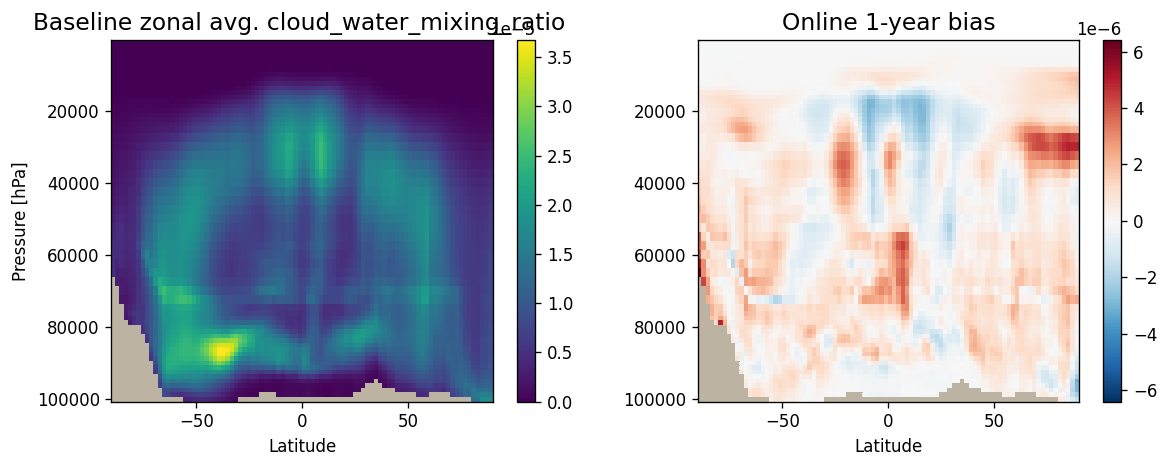

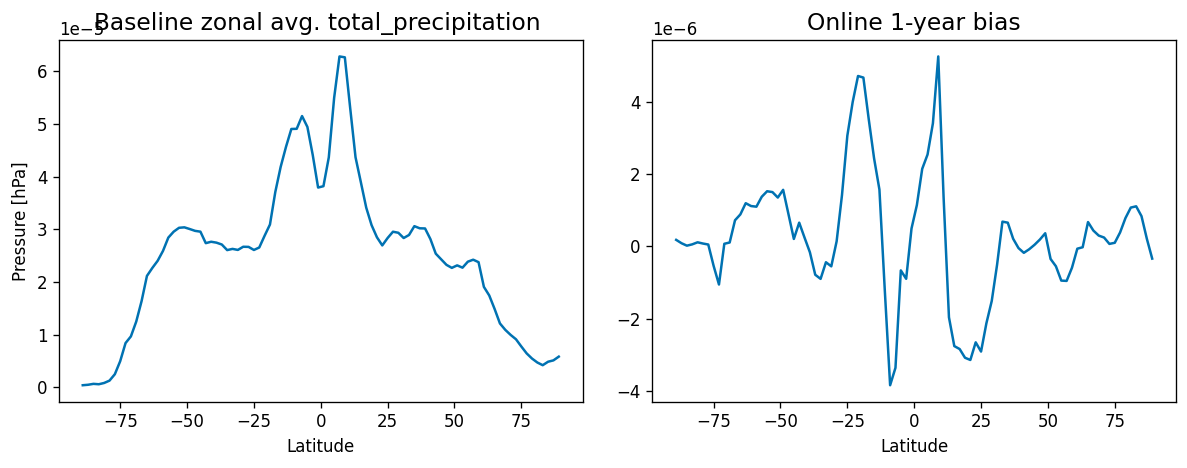

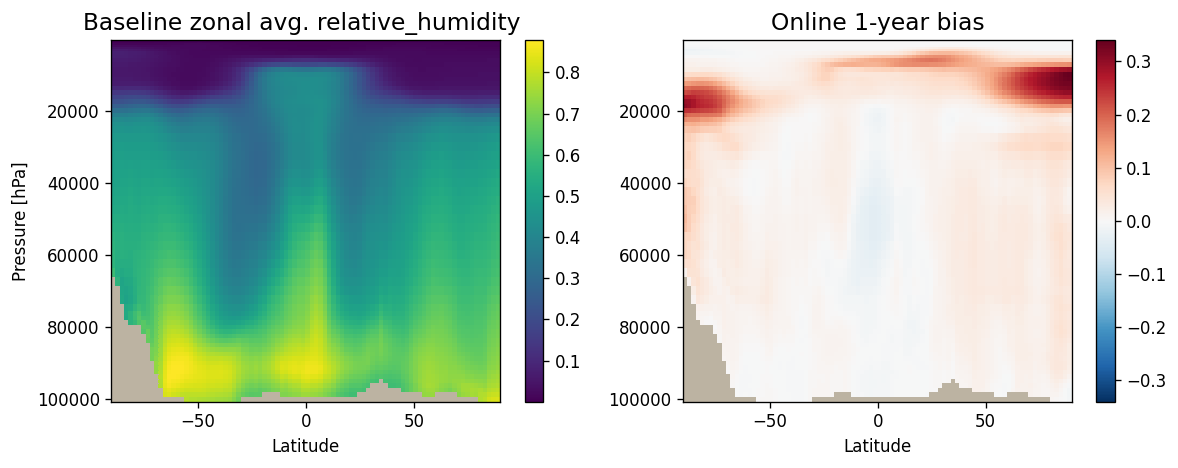

In [79]:
scale_factors = {
    "specific_humidity": 1000,
    "": "s"
}

for i in range(len(fields)):
    online_ds = last_3mo_results[i][fields[i]]
    offline_ds = last_3mo_results[i + len(fields)][fields[i]]

    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10,4))
    if i != 3:
        kwargs = dict(y="pressure", yincrease=False)
        online_ds = vcm.interpolate_to_pressure_levels(online_ds, delp, common.LEVELS, dim="z")
        offline_ds = vcm.interpolate_to_pressure_levels(offline_ds, delp, common.LEVELS, dim="z")
    else:
        kwargs = {}
    offline_ds.plot(ax=ax[0], **kwargs)
    (online_ds - offline_ds).plot(ax=ax[1], **kwargs)
    if i == 0:
        ax[0].text(-0.1, 1.03, "b)", fontdict=dict(size=13, weight="bold"), transform=ax[0].transAxes)
        ax[1].text(-0.1, 1.03, "c)", fontdict=dict(size=13, weight="bold"), transform=ax[1].transAxes)
        ax[0].set_title("Baseline zonal avg. temperature ", size=14)
    else:
        ax[0].set_title(f"Baseline zonal avg. {fields[i]} ", size=14)

    ax[1].set_title("Online 1-year bias", size=14)
    ax[0].set_ylabel("Pressure [hPa]")
    ax[1].set_ylabel("")
    ax[0].set_xlabel("Latitude")
    ax[1].set_xlabel("Latitude")
    plt.tight_layout()
    plt.show()



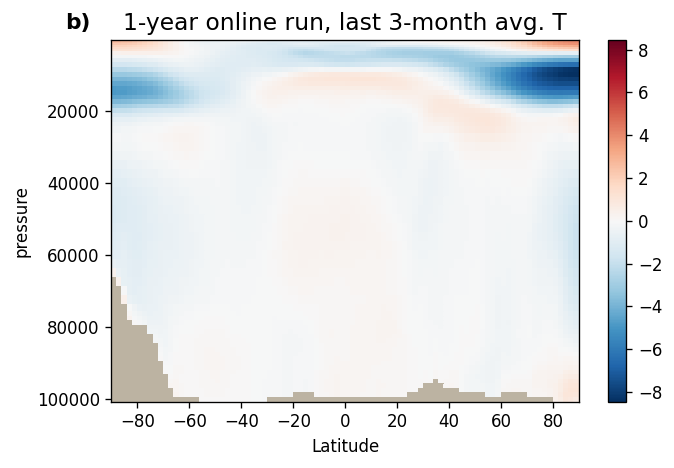

In [88]:
fix, ax = plt.subplots(dpi=120, figsize=(6,4))
kwargs = dict(y="pressure", yincrease=False)
online_ds = last_3mo_results[0]["air_temperature"]
offline_ds = last_3mo_results[5]["air_temperature"]
online_ds = vcm.interpolate_to_pressure_levels(online_ds, delp, common.LEVELS, dim="z")
offline_ds = vcm.interpolate_to_pressure_levels(offline_ds, delp, common.LEVELS, dim="z")
(online_ds - offline_ds).plot(ax=ax, **kwargs)
ax.text(-0.1, 1.03, "b)", fontdict=dict(size=13, weight="bold"), transform=ax.transAxes)

ax.set_title("1-year online run, last 3-month avg. T", size=14)
ax.set_xlabel("Latitude")
plt.tight_layout()
plt.show()
